In [265]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import spearmanr, shapiro, pearsonr, ttest_ind, mannwhitneyu, chi2_contingency, kruskal, f_oneway

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder

In [266]:
import warnings
warnings.filterwarnings('ignore')

### Заполнение пропусков и предобработка

In [267]:
df = pd.read_csv('raw_data.csv', skipinitialspace=True, sep=',', index_col=0)
df['год'] = df['год'].astype(int).astype(str)
df.head()


,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22.0,NaN,...,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,40.0,NaN,...,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42.0,NaN,...,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27.0,NaN,...,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,46.0,NaN,...,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0


In [268]:
df[df['среднемесячная_температура_на_улице'] == max(df['среднемесячная_температура_на_улице'])]['время_года']

11    Лето
Name: время_года, dtype: object

In [269]:
# обработка сырых данных
# df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
# df['климат'].replace('Cубтроп океанич', 'Cубтропический океанический', inplace=True)
# df['предпочтительное_изменение_температуры'].replace({'Холодн': 'Холоднее', 'Тепле': 'Теплее'}, inplace=True)
# df['режим_при_смешанном_типе_охлаждения'] = df['режим_при_смешанном_типе_охлаждения'].fillna('нет')
# df['способ_обогрева'] = df['способ_обогрева'].fillna('нет')
# df.to_csv('raw_data.csv')

In [270]:
# убираем выбросы через пороговое значение, показания выше которого вызывают вопросы
df = df[df['температура_воздуха_в_помещении'] < 40]
df = df[df['среднемесячная_температура_на_улице'] < 40]
df = df[df['скорость_воздуха'] < 8]

In [271]:
# заполняем возраст по группам из городов
gb = df.groupby('город')['возраст']
md = gb.median()
for city in md.index:
    if not md.isna()[city]:
        df['возраст'][df['город'] == city] = df['возраст'][df['город'] == city].fillna(md[city])
    else:
        df['возраст'][df['город'] == city] = df['возраст'][df['город'] == city].fillna(df['возраст'].median())

In [272]:
# заполняем пол по группам из городов, сохраняя отношение М/Ж в группах
gb = df.groupby('город')['пол']
glbrel = df['пол'].value_counts()['Мужской'] / df['пол'].value_counts()['Женский']
for key, it in gb:
    vc = it.value_counts()
    if vc.size and vc['Мужской'] and vc['Женский']:
        rel = vc['Мужской'] / vc['Женский']
    else:
        rel = glbrel
    ln = len(it)
    f = int(round(ln / (rel + 1)))
    m = ln - f
    df['пол'].fillna({it.index[i]: ('Мужской' if i < m else 'Женский') for i in range(ln)}, inplace=True)

In [273]:
# заполняем рост по возрастным группам
df["возраст"] = df['возраст'].astype(int)
df.loc[df['рост'] <= df['рост'].quantile(0.01), 'рост'] = np.nan
gb1 = df.groupby(['возраст'])['рост']
for key, item in gb1:
    key_mean = gb1.get_group(key).median()
    df["рост"] = df["рост"].fillna(key_mean)

In [274]:
# заполняем вес по возрастным группам
gb2 = df.groupby(['возраст'])['вес']
for key, item in gb2:
    key_mean = gb2.get_group(key).median()
    df["вес"] = df["вес"].fillna(key_mean)

In [275]:
# заполняем занавески, сохраняя отношение есть занавески/нет занавесок
vc = df['занавески'].value_counts()
rel = vc[1] / vc[0]
z = int(round(len(df) / (rel + 1)))
o = ln - z
df['занавески'].fillna({i: (1 if i < o else 0) for i in df.index}, inplace=True)

In [276]:
# заполняем окно и двери, сохраняя отношение есть/нет
def zapolnenie(st2):
    gb = df.groupby(['климат','время_года'])[st2.name]
    dolya = 0
    for group_name, df_group in gb:
        if df_group.isna().sum() == 0:
            dolya_0 = df_group.value_counts()[0.0]/(len(df_group))
            dolya += dolya_0
    dolya = dolya/len(df_group)
    for group_name, df_group in gb:
        if df_group.isna().sum() != 0:
            kolvo_0 = int(round(dolya * len(df_group),0))
            df[st2.name] = df[st2.name].fillna({df_group.index[i]: (0.0 if i < kolvo_0 else 1.0) for i in range(len(df_group))})

zapolnenie(df['окно'])
zapolnenie(df['двери'])
zapolnenie(df['вентилятор'])

In [277]:
# удаление столбца, в котором слишком много пропусков
df.drop('отопление', axis=1, inplace=True)

### Работа с корреляциями

In [278]:
df['год'] = df['год'].astype(str)
df['countmen'] = 1
# Столбец countmen для будущего подсчета людей в каждой группе
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,0.26,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0,1
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.08,170.2,63.0,0.0,0.0,0.0,0.0,32.8,0,1
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,0.21,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0,1
6,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,0.10,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0,1
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,0.15,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0,1


In [279]:
subs = {'ощущение_температуры': 'cat',        
    'ощущение_температуры_(bool)': 'cat',
    'предпочтительное_изменение_температуры': 'cat',
     'ощущение_движения_воздуха_(bool)': 'cat',
    'предпочтительное_изменение_движения_воздуха': 'cat',
    'оценка_комфорта': 'cat'}
types = {
    'год': 'cat',
    'город': 'cat',
    'страна': 'cat',
    'возраст': 'num',
    'пол': 'cat',    
    'утепление':'num',    
    'количество_рекламаций': 'num',
    'время_года': 'cat', 
    'климат': 'cat', 
    'способ_охлаждения': 'cat', 
    'режим_при_смешанном_типе_охлаждения': 'cat', 
    'способ_обогрева': 'cat', 
    'температура_воздуха_в_помещении': 'num',     
    'rh': 'num', 
    'скорость_воздуха': 'num', 
    'занавески': 'cat',
    'вентилятор': 'num',
    'окно': 'cat', 
    'двери': 'cat', 
    'среднемесячная_температура_на_улице': 'num'}
def hi2(g1, g2):
    ct = pd.crosstab(g1, g2)
    chi2 = chi2_contingency(ct)
    return (chi2.statistic / (df.shape[0] * (min(df.shape) - 1))) ** 0.5, chi2.pvalue

# функция, которая вычисляет корреляцию и p-уровень между двумя факторами, на основе их типа
def corr(g1, g2, type1, type2):
    res = 0
    # разные шкалы
    if type1 != type2:
        norm = 0
        if type1 == 'cat':
            norm = shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            gs = [g2[g1 == i] for i in g1.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            ln = len(g1.unique())
        else:
            gs = [g1[g2 == i] for i in g2.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            norm = shapiro(g1).pvalue >= 0.05 # проверка на нормальность
            ln = len(g2.unique())
        if not norm:
            if ln == 2:
                res = mannwhitneyu(*gs)
                method = 0
            else:
                res = kruskal(*gs)
                method = 1
        else: 
            if ln == 2:
                res = ttest_ind(*gs)
                method = 2
            else:
                res = f_oneway(*gs)
                method = 3
    else: #одинаковые шкалы
        if type1 == 'cat':
            method = 4
            res = hi2(g1, g2)
        else:
            norm = shapiro(g1).pvalue >= 0.05 and shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            if not norm:
                res = spearmanr(g1, g2)
                method = 5
            else:
                res = pearsonr(g1, g2)
                method = 6
    return res[0], res[1], method
# составляем хитмап корреляций
cols = list(types)
colssubs = list(subs)
resflat = []
res = np.zeros((len(cols), len(colssubs)), dtype='float32')
meths = np.zeros_like(res, dtype='O')
for i in range(len(cols)):
    for j in range(len(colssubs)):
        f1, f2 = cols[i], colssubs[j]
        statistics, pvalue, meth = corr(df[f1], df[f2], types[f1], subs[f2])
        res[i, j] = statistics
        meths[i, j] = meth
        if pvalue < 0.05 and statistics > 0.5:
            resflat.append([f1 + ' ' + f2, statistics, pvalue, meth])
for meth in np.unique(meths):
    idx = meths == meth
    if meth <= 4:
        g = res[idx]
        for i in range(len(g)):
            if g[i] == np.nan:
                g[i] = 0
            elif g[i] >= 20:
                g[i] = 0.99
            else:
                g[i] = g[i] / 20
        print(g)


[0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99]
[0.6959851  0.11388393        nan 0.22293904        nan 0.99
 0.5569464         nan 0.6822856         nan 0.99       0.80506194
        nan 0.99              nan 0.99       0.9934853         nan
 0.99              nan 0.99       0.23321006        nan 0.7389325
        nan 0.99       0.52888995        nan 0.78151363        nan
 0.99       0.15818544        nan 0.03304569        nan 0.99
 0.8508371         nan 0.99              nan]
[0.00506221 0.00032652 0.00171174 0.         0.00264648 0.0030858
 0.00641639 0.00124479 0.00292382 0.         0.00342573 0.00354289
 0.00506221 0.00032652 0.00171174 0.         0.00264648 0.0030858
 0.00210713 0.00109447 0.00119726 0.00131627 0.00093154 0.00123165
 0.00378121 0.00081818 0.00191062 0.         0.00292274 0.00147114
 0.00430219 0.00079553 0.00224333 0.         0.00252424 0.00351538
 0.00315888 0.00044932 0.00130474 0.         0.00061701 0.00215364
 0.00304612 0.00063048 0.00120903 0.00053773 0.00098888 

In [280]:
# Шкалы всех столбцов для последующей корреляции
types = {
    # 'год': 'cat',
    'город': 'cat',
    # 'страна': 'cat',
    'возраст': 'num',
    # 'пол': 'cat',    
    'утепление':'num',    
    'количество_рекламаций': 'num',
    'время_года': 'cat', 
    'климат': 'cat', 
    'способ_охлаждения': 'cat', 
    # 'режим_при_смешанном_типе_охлаждения': 'cat', 
    'способ_обогрева': 'cat', 
    # 'температура_воздуха_в_помещении': 'num',     
    'rh': 'num', 
    'скорость_воздуха': 'num', 
    # 'занавески': 'cat',
    'вентилятор': 'num',
    # 'окно': 'cat', 
    # 'двери': 'cat', 
    'среднемесячная_температура_на_улице': 'num'}
subs = {'ощущение_температуры': 'cat',        
    'ощущение_температуры_(bool)': 'cat',
    'предпочтительное_изменение_температуры': 'cat',
    # 'ощущение_движения_воздуха_(bool)': 'cat',
    'предпочтительное_изменение_движения_воздуха': 'cat',
    'оценка_комфорта': 'cat'}

# Создание функций для добавления категориальных столбцов датафрейма
def changerecl(x):
    if x <= 1:
        return 'мало'
    if x == 2:
        return 'средне'
    if x > 2:
        return 'много'
    
def changeage(x):
    if x <= 44:
        return 'молодой возраст'
    if 45 <= x <= 59:
        return 'средний возраст'
    if x >= 60:
        return 'пожилой возраст'

def standr_comf_rh(df):
    '''Источник:
            https://oborona.media/microclimate-at-work/'''
    if 40 <= df['rh'] <= 60:
        return 'OK'
    else:
        return 'not OK'
# Функции для выполнения корреляций

#реализация хи-квадрат
def hi2(g1, g2):
    ct = pd.crosstab(g1, g2)
    chi2 = chi2_contingency(ct)
    return (chi2.statistic / (df.shape[0] * (min(df.shape) - 1))) ** 0.5, chi2.pvalue

# функция, которая вычисляет корреляцию и p-уровень между двумя факторами, на основе их типа
def corr(g1, g2, type1, type2):
    res = 0
    # разные шкалы
    if type1 != type2:
        norm = 0
        if type1 == 'cat':
            norm = shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            gs = [g2[g1 == i] for i in g1.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            ln = len(g1.unique())
        else:
            gs = [g1[g2 == i] for i in g2.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            norm = shapiro(g1).pvalue >= 0.05 # проверка на нормальность
            ln = len(g2.unique())
        if not norm:
            if ln == 2:
                res = mannwhitneyu(*gs)
                method = 0
            else:
                res = kruskal(*gs)
                method = 1
        else: 
            if ln == 2:
                res = ttest_ind(*gs)
                method = 2
            else:
                res = f_oneway(*gs)
                method = 3
    else: #одинаковые шкалы
        if type1 == 'cat':
            method = 4
            res = hi2(g1, g2)
        else:
            norm = shapiro(g1).pvalue >= 0.05 and shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            if not norm:
                res = spearmanr(g1, g2)
                method = 5
            else:
                res = pearsonr(g1, g2)
                method = 6
    return res[0], res[1], method

In [281]:
# Категоризация требуемых данных в отдельных столбцах
df['реклам_категория'] = df['количество_рекламаций'].map(changerecl)
df['возрастная_категория'] = df['возраст'].map(changeage)
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
6,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст


In [282]:
dfmeanage = df[['пол', 'страна', 'возраст']].groupby(['пол', 'страна']).mean().round().astype(int)
dfmeanage.head()
# Рассчитать средний возраст респондентов по полу и стране

возраст
пол     страна            
Женский Австралия       46
        Индия           35
        США             38
Мужской Австралия       43
        Индия           37

In [283]:
goodtemp = df.loc[df['предпочтительное_изменение_температуры'] == 'Без изменений']
goodtemp.head()
# Сбор всех данных с комфортной температурой

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст
12,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст


In [284]:
dfcomftemp = goodtemp[['температура_воздуха_в_помещении', 'возрастная_категория']].groupby('возрастная_категория').mean().round(1)
dfcomftemp.head()
# Рассчитать среднюю комфортную температуру в зависимости от возрастной категории

,температура_воздуха_в_помещении
возрастная_категория,
молодой возраст,24.7
пожилой возраст,25.4
средний возраст,24.5


In [285]:
df3 =  goodtemp[['страна', 'пол', 'countmen']].groupby(['страна', 'пол']).count()
df3.reset_index(inplace=True)
for i in range(len(df3)):
    df3['countmen'][i] = round(df3['countmen'][i] / len(df.loc[(df['страна'] == df3['страна'][i]) & (df['пол'] == df3['пол'][i])]) * 100)

df = df.merge(df3, left_on=['пол', 'страна'], right_on=['пол', 'страна'])
df = df.rename(columns = {'countmen_x': 'countmen', 'countmen_y': 'precent_satisf'})
df.head()

# Добавить столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56


In [286]:
dftypeohl = df[['способ_охлаждения', 'температура_воздуха_в_помещении', 'rh']].groupby('способ_охлаждения').median()
dftypeohl.head()
# Рассчитать медианное значение температуры и влажности для каждого типа охлаждения 

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.30,46.3
Кондиционирование,24.35,43.7
Смешанный,24.65,56.4


In [287]:
pivot = pd.pivot_table(df, index=['страна', 'пол', 'возрастная_категория'], values=['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh'], 
                       aggfunc='mean').round(2)

'''
Составить сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе 
и подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.
'''
pivot.head()


rh  \
страна    пол     возрастная_категория          
Австралия Женский молодой возраст       61.37   
                  пожилой возраст       44.55   
                  средний возраст       61.37   
          Мужской молодой возраст       61.67   
                  пожилой возраст       64.37   

                                        температура_воздуха_в_помещении  \
страна    пол     возрастная_категория                                    
Австралия Женский молодой возраст                                 23.84   
                  пожилой возраст                                 24.90   
                  средний возраст                                 24.10   
          Мужской молодой возраст                                 24.15   
                  пожилой возраст                                 24.73   

                                        температура_воздуха_на_улице  
страна    пол     возрастная_категория                                
Австралия Женский молодой возраст                                NaN  
                  пожилой возраст                                NaN  
                  средний возраст                                NaN  
          Мужской молодой возраст                                NaN  
                  пожилой возраст                                NaN

In [288]:
df['стандр_комф_вл'] = df.apply(standr_comf_rh, axis=1)
''' 
Самостоятельно найти информацию по стандартной комфортной относительной влажности в помещениях (в нашем случае - офисы). 
Создать новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. 
Категории назначить самостоятельно.
'''
df.head()


,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf,стандр_комф_вл
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,OK
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,not OK
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,OK
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK


<Axes: >

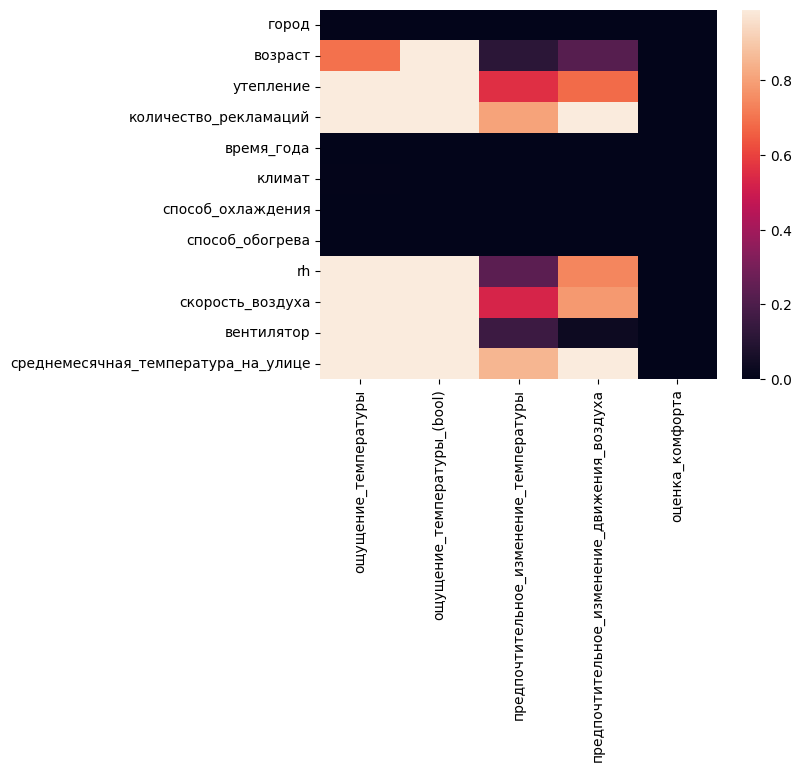

In [289]:
# составляем хитмап корреляций
cols = list(types)
colssubs = list(subs)
resflat = []
res = np.zeros((len(cols), len(colssubs)), dtype='float32')
meths = np.zeros_like(res, dtype='O')
for i in range(len(cols)):
    for j in range(len(colssubs)):
        f1, f2 = cols[i], colssubs[j]
        statistics, pvalue, meth = corr(df[f1], df[f2], types[f1], subs[f2])
        res[i, j] = statistics
        meths[i, j] = meth
        if pvalue < 0.05 and statistics > 0.5:
            resflat.append([f1 + ' ' + f2, statistics, pvalue, meth])
for meth in np.unique(meths):
    idx = meths == meth
    if meth <= 4:
        g = res[idx]
        for i in range(len(g)):
            if g[i] == np.nan:
                g[i] = 0
            elif g[i] >= 20:
                g[i] = 0.99
            else:
                g[i] = g[i] / 20
        res[idx] = g
dfress = pd.DataFrame(index=cols, columns=colssubs, data=res)
sns.color_palette('Blues')
sns.heatmap(dfress.fillna(0))


In [ ]:
'''Судя по корреляциям, количество рекламаций имеет очень хорошую связь с ощущением температуры и предпочтительным ее изменением. Ощущение температуры имеет связь непосредственно с возрастом, а также с среднемесячной температурой на улице.
Из чего следует вывод, что ради меньшего количество рекламаций, продукцию стоит ориентировать на территории с определенной среднемесячной температурой и определенной возрастной группе людей.'''

### Проверка гипотез

In [290]:
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf,стандр_комф_вл
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,OK
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,not OK
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,OK
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK


In [291]:
corr(df['способ_охлаждения'], df['оценка_комфорта'], 'cat', 'cat')

(0.0403780389385634, 0.3225687848299499, 4)

Способ охлаждения не вляет на оценку комфорта. Значение корреляции маленькое, следовательно, зависимость очень слабая. Уровень доверия больше 0.05, значит, ответу нельзя доверять.

In [292]:
corr(df['пол'], df['оценка_комфорта'], 'cat', 'cat')

(0.02309194819726559, 0.7127152082008428, 4)

Здесь уровень корреляции также маленький, однако p-уровень больше 0.05, поэтому по имеющимся данным выводов мы делать не можем

In [293]:
df['возрастная_категория'] = df['возраст'].map(changeage)
corr(df['возрастная_категория'], df['оценка_комфорта'], 'cat', 'cat')

(0.042029871066315255, 0.2298590866347347, 4)

Здесь уровень корреляции также маленький, однако p-уровень больше 0.05, поэтому по имеющимся данным выводов мы делать не можем

In [294]:
corr(df['количество_рекламаций'], df['оценка_комфорта'], 'num', 'cat')

(nan, nan, 1)

Здесь, к сожалению, не удалось подсчитать корреляцию, так как слишком много пропусков

In [295]:
corr(df['страна'], df['оценка_комфорта'], 'cat', 'num') 

(nan, nan, 1)

Здесь, к сожалению, не удалось подсчитать корреляцию, так как слишком много пропусков

### Построение регрессионной модели

In [296]:
import warnings
warnings.filterwarnings('ignore')

In [297]:
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf,стандр_комф_вл
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,OK
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,not OK
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,OK
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK


In [298]:
# здесь слишком много пропусков
df.drop('температура_воздуха_на_улице', axis=1, inplace=True)

In [299]:
# столбцы, которые могут влиять на температуру воздуха в помещении
factors_list = ['время_года', 
         'климат', 
         'способ_охлаждения', 
         'режим_при_смешанном_типе_охлаждения', 
         'температура_воздуха_в_помещении',
         'способ_обогрева', 
         'rh', 
         'скорость_воздуха', 
         'занавески', 
         'вентилятор', 
         'окно', 
         'двери', 
         'среднемесячная_температура_на_улице']
factors = df[factors_list]

In [300]:
# шкалы этих столбцов
types = {
    'время_года': 'cat', 
    'климат': 'cat', 
    'способ_охлаждения': 'cat', 
    'режим_при_смешанном_типе_охлаждения': 'cat', 
    'способ_обогрева': 'cat', 
    'температура_воздуха_в_помещении': 'num', 
    'температура_воздуха_на_улице': 'num', 
    'rh': 'num', 
    'скорость_воздуха': 'num', 
    'занавески': 'cat',
    'вентилятор': 'cat', 
    'окно': 'cat', 
    'двери': 'cat', 
    'среднемесячная_температура_на_улице': 'num'
}

In [301]:
# функция, делающая график зависимости двух факторов на основе их типа
def get_plot(col1, col2, type1, type2, i, j):
    global ax
    # если разные шкалы - боксплот
    if type1 != type2:
        if type1 == 'cat':
            sns.boxplot(x=col1, y=col2, ax=ax[i, j])
        else:
            sns.boxplot(x=col2, y=col1, ax=ax[i, j])
    else: # иначе, т.к. одна из шкал - температура, то есть количественная, - скаттерплот
        sns.scatterplot(x=col1, y=col2, ax=ax[i, j], legend=False)

In [302]:
# применяем label encode к климату, так проще визуализировать на графике
unq = factors['климат'].unique()
enc = {unq[i]: i for i in range(len(unq))}
factors['климат'] = factors['климат'].apply(lambda x: enc[x])

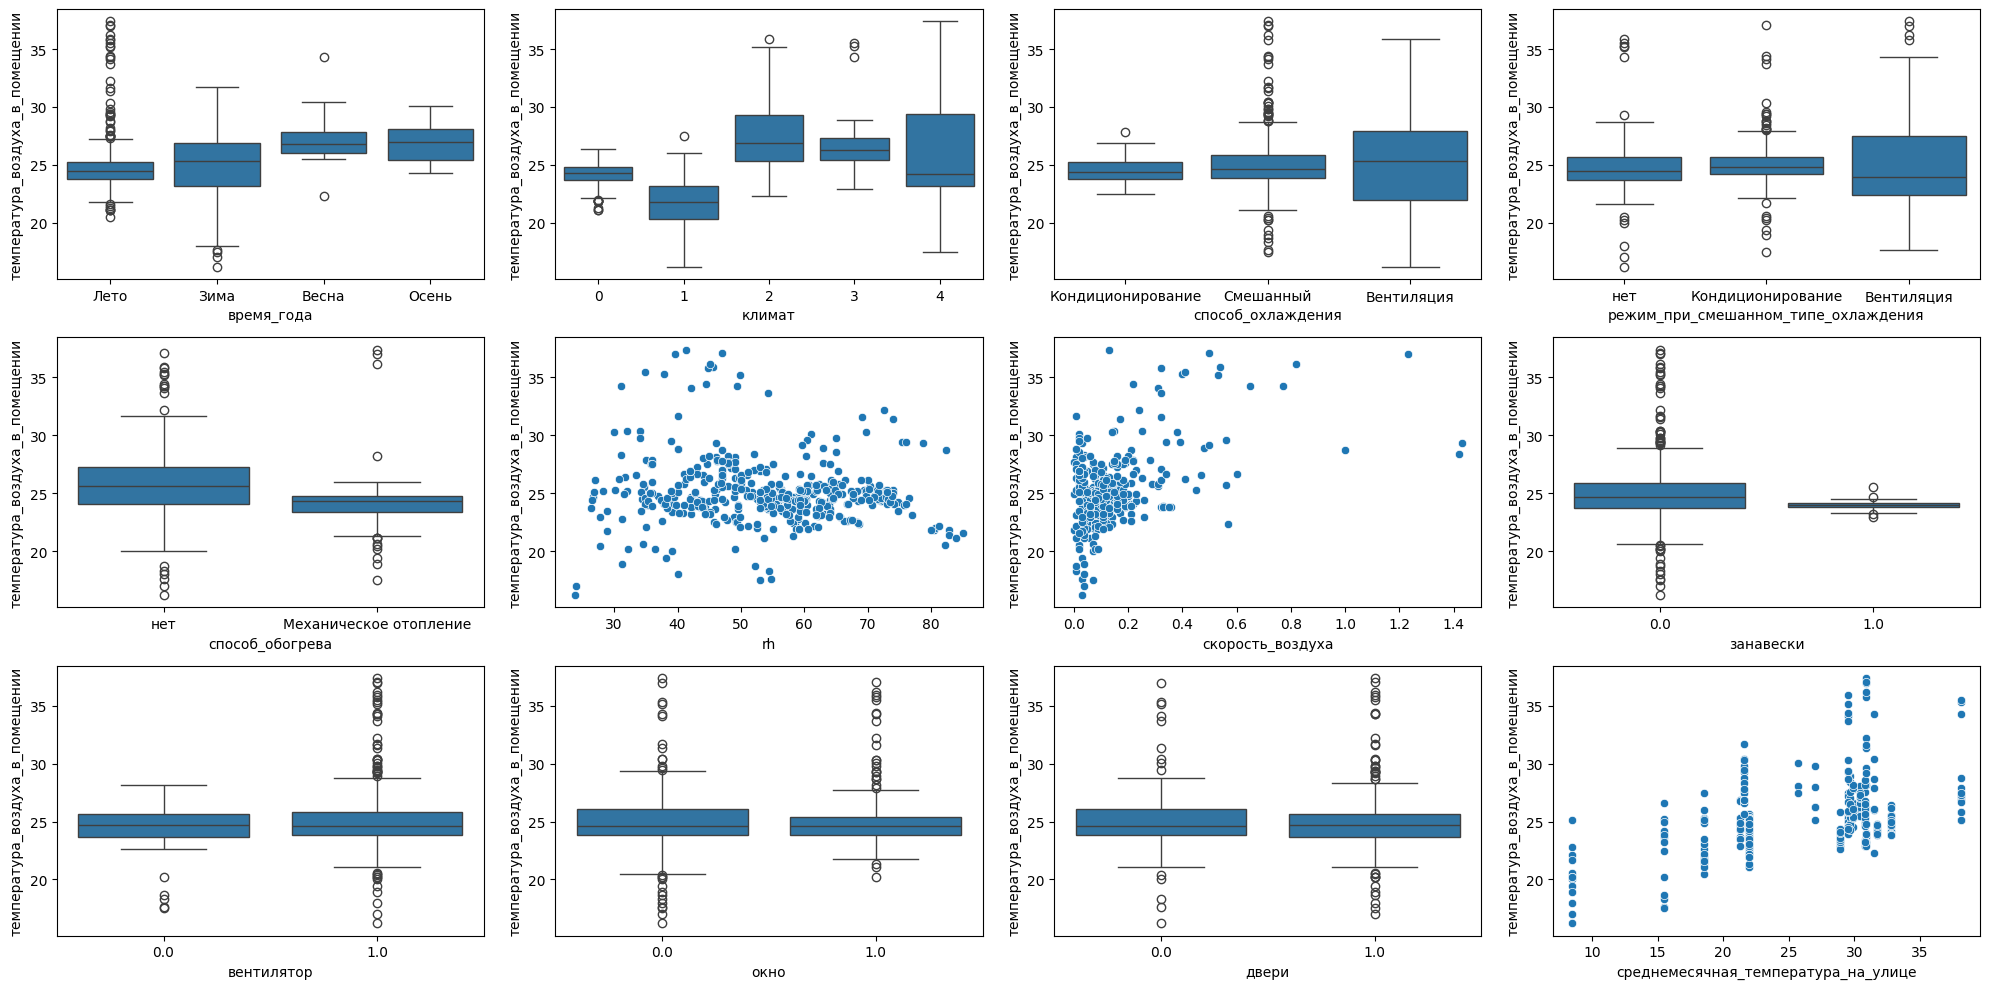

In [303]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
i = 0
for col in factors.columns:
    if col != 'температура_воздуха_в_помещении':
        get_plot(factors[col], df['температура_воздуха_в_помещении'], types[col], types['температура_воздуха_в_помещении'], i // 4, i % 4)
        i += 1
fig.tight_layout()

In [304]:
res = []
f2 = 'температура_воздуха_в_помещении'
for i in range(len(factors_list)):
    f1 = factors_list[i]
    if f1 != f2:
        res.append([*corr(factors[f1], factors[f2], types[f1], types[f2]), f1])
res.sort(key=lambda x: x[1] if x[1] < 0.05 else 1e9, reverse=False)
res

[[182.0219169567037, 2.743358059798561e-38, 1, 'климат'],
 [0.42179035551304545,
  4.718815884032914e-21,
  5,
  'среднемесячная_температура_на_улице'],
 [37698.0, 2.9537861270668604e-17, 0, 'способ_обогрева'],
 [36.66660650218179, 5.412737559554017e-08, 1, 'время_года'],
 [0.21627819420018726, 3.225685409526806e-06, 5, 'скорость_воздуха'],
 [3154.5, 0.0012914470540354307, 0, 'занавески'],
 [10.914894905080471,
  0.004264427016542392,
  1,
  'режим_при_смешанном_типе_охлаждения'],
 [-0.10508359632844205, 0.024990261116553867, 5, 'rh'],
 [3.0997698469121837, 0.2122723999954351, 1, 'способ_охлаждения'],
 [11065.0, 0.7934141651624057, 0, 'вентилятор'],
 [24187.0, 0.911866619920265, 0, 'окно'],
 [26239.5, 0.7912730284858436, 0, 'двери']]

In [305]:
# выделяем те факторы, влияние которых наибольшее
x = df[['время_года', 'климат', 'способ_обогрева', 'среднемесячная_температура_на_улице', 'вентилятор', 'скорость_воздуха']]
y = df['температура_воздуха_в_помещении']

In [306]:
# применяем энкодинг к категориальным столбцам
for col in x.columns:
    if x[col].dtype not in ['float', 'int']:
        enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        x[(col + ': ' + x[col].unique()).tolist()] = enc.fit_transform(x[[col]])
        x.drop(col, axis=1, inplace=True)

In [307]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [308]:
# строим модель и проверяем её эффективность
reg = LinearRegression()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.6486053901517747

In [309]:
mse(y_test, reg.predict(x_test)) ** 0.5

1.8124064203743933

In [310]:
# сохраняем модель
from joblib import dump, load
dump(reg, 'models/regressor_without_temp.joblib')

['models/regressor_without_temp.joblib']

In [311]:
# загружаем модель
reg = load('models/regressor_without_temp.joblib')

df.to_csv('corrected_data.csv')
